In [1]:
# Install the package from bitbucket.
!pip uninstall arqee -y # remove existing installation, if any
!pip install ../

Found existing installation: arqee 1.0.1
Uninstalling arqee-1.0.1:
  Successfully uninstalled arqee-1.0.1
Processing /home/gillesv/PycharmProjects/public/arqee
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for arqee: filename=arqee-1.0.1-py3-none-any.whl size=28118 sha256=a294e556b086ae72088dcf75b4a618ef6858916ba12b123576f6a345f9d7d54e
  Stored in directory: /tmp/pip-ephem-wheel-cache-s6r4r6mn/wheels/b7/ca/37/d1c63c9d5d63f8510a3fbeaf2fcc597c3d982c7ade1951692f
Successfully built arqee


In [2]:
# Some additional libraries for the toturial
!pip install matplotlib
!pip install tqdm
!pip install gif

In [3]:
# Donwload a small sample of test data
# This will download +-240Mb of data under ./local__data/sample_data
import os
import arqee
current_directory = os.getcwd()
download_loc = os.path.join(current_directory,"local_data")
arqee.download_data_sample(download_loc,verbose=True)

/home/gillesv/PycharmProjects/public/arqee/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching contents from: https://api.github.com/repos/GillesVanDeVyver/us_cardiac_sample_data/contents/sample_data


 17%|███████▌                                     | 1/6 [00:00<00:02,  2.01it/s]

Downloaded: /home/gillesv/PycharmProjects/public/arqee/tutorial/local_data/sample_data/a2c.mp4


 33%|███████████████                              | 2/6 [00:07<00:16,  4.14s/it]

Downloaded: /home/gillesv/PycharmProjects/public/arqee/tutorial/local_data/sample_data/a2c.npy


 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.41s/it]

Downloaded: /home/gillesv/PycharmProjects/public/arqee/tutorial/local_data/sample_data/a4c.mp4


 67%|██████████████████████████████               | 4/6 [00:12<00:07,  3.57s/it]

Downloaded: /home/gillesv/PycharmProjects/public/arqee/tutorial/local_data/sample_data/a4c.npy


 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.42s/it]

Downloaded: /home/gillesv/PycharmProjects/public/arqee/tutorial/local_data/sample_data/alax.mp4


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.21s/it]

Downloaded: /home/gillesv/PycharmProjects/public/arqee/tutorial/local_data/sample_data/alax.npy


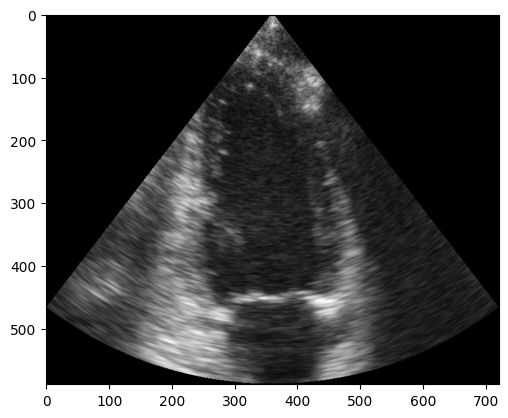

In [4]:
# Load a sample
import os
import numpy as np
import matplotlib.pyplot as plt
sample_alax = np.load(os.path.join(download_loc,"sample_data/a2c.npy"))
# sample_alax is an ndarray of shape (nb_frames,height,width) with values in range [0,255]
sample_frame = sample_alax[-1]
plt.imshow(sample_frame, cmap='gray')
plt.show()

In [5]:
'''
we apply classic left ventricle and myocardium segmentation and divide the segmentation into 8 regions:
basal_left,mid_left,apical_left,apical_right,mid_right,basal_right,annulus_left,annulus_right
There are three segmentation models available in arqee:
    - 'nnunet_hunt4_alax' (33M parameters)
    - 'nnunet_hunt4_a2c_a4c'  (33M parameters)
    - 'nnunet_camus' (33M parameters)
'''
model_name_seg = 'nnunet_hunt4_a2c_a4c'
arqee.download_and_set_up_model(model_name_seg)

Download link for model with backbone nnunet_hunt4_a2c_a4c is ('gillesvdv/nnunet_hunt4_a2c_a4c', 'nnunet_hunt4_a2c_a4c.zip')
Model downloaded to /home/gillesv/PycharmProjects/public/arqee/.venv/lib/python3.10/site-packages/arqee/models/models--gillesvdv--nnunet_hunt4_a2c_a4c/snapshots/fe50709e042f069eaf5f5b40c3e42441fa7a8938/nnunet_hunt4_a2c_a4c.zip
Archive:  /home/gillesv/PycharmProjects/public/arqee/.venv/lib/python3.10/site-packages/arqee/models/models--gillesvdv--nnunet_hunt4_a2c_a4c/snapshots/fe50709e042f069eaf5f5b40c3e42441fa7a8938/nnunet_hunt4_a2c_a4c.zip
  inflating: /home/gillesv/PycharmProjects/public/arqee/.venv/lib/python3.10/site-packages/arqee/models/nnunet_hunt4_a2c_a4c/model.onnx  
Model nnunet_hunt4_a2c_a4c.zip set up successfully!


In [6]:
# Once the model is set up in arqee, we can load it as follows:
model_object_seg = arqee.load_model(model_name_seg)

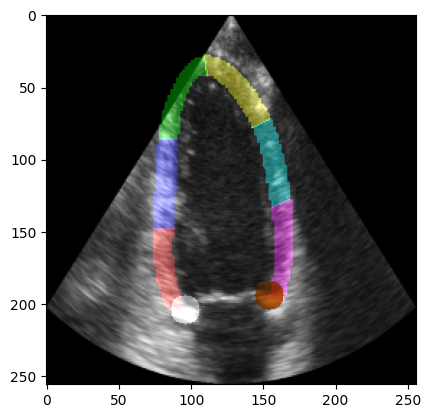

In [7]:
# Now we can run the segmentation and divide the result into the 8 regions specified above
sample_frame_with_channel = np.expand_dims(sample_frame, axis=0) # add channel dimension
segmentation_sample = model_object_seg.predict_img(sample_frame_with_channel,verbose=False)
divided_indices=[0,1,2,3,4,5,6,7]
segmentation_regions = arqee.divide_segmentation(segmentation_sample,new_labels=divided_indices)
# this is an array of shape (8,256,256) with the 8 masks of the 8 regions. 
# Note some regions might be overlapping
visualization=arqee.create_visualization(sample_frame,segmentation_regions,labels=divided_indices)
plt.imshow(visualization)
plt.show()

In [8]:
# We calculate the gcnr quality metric for each region by using the myocardium region as region of interest and the lv lumen as background
# Let's set up the pixel based method
# Available pixel-based models are:
# - 'pixel_based_gcnr'
# - 'pixel_based_cnr'
# - 'pixel_based_cr'
# - 'pixel_based_intensity'
pixel_based_model=arqee.set_up_pixel_based_method("pixel_based_gcnr")

In [9]:
gcnr_values = pixel_based_model.predict_img(sample_frame_with_channel,segmentation=segmentation_sample,
                                          apply_linear_model=False)
print(gcnr_values)

# We can also apply a linear model to the gcnr values to get the quality labels. 
# This linear model is fitted on the validation set to map from quality metrics to quality labels.
quality_labels = pixel_based_model.predict_img(sample_frame_with_channel,segmentation=segmentation_sample,
                                             apply_linear_model=True, convert_to_labels=True)
print(quality_labels)

The given data has shape: (1, 1, 589, 721).
 The data will be resized to (batch_size, 1, 256, 256) before running inference.
[0.9329736  0.91941433 0.76534772 0.75057466 0.67491072 0.82854624
 0.91464954 0.87357164]
The given data has shape: (1, 1, 589, 721).
 The data will be resized to (batch_size, 1, 256, 256) before running inference.
['Excellent' 'Excellent' 'Poor' 'not visible' 'not visible' 'Good'
 'Excellent' 'Excellent']


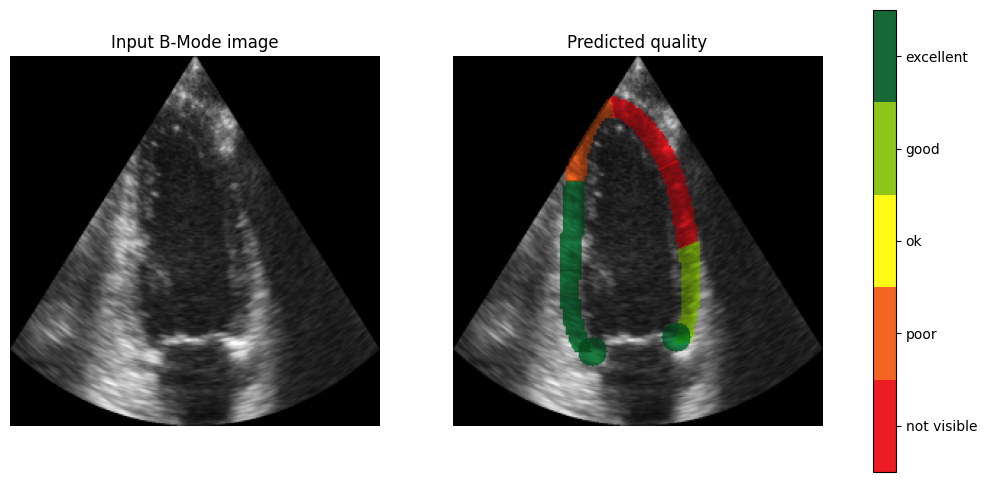

In [10]:
# Let's visualize the quality predictions from the pixel-based method
from skimage.transform import resize

sample_frame_resized = resize(sample_frame, (256, 256), preserve_range=True)
_ = arqee.plot_quality_prediction_result(sample_frame_resized,segmentation_sample,quality_labels)
plt.show()